In [34]:
import os
import ultralytics
import yolox
import supervision
from ultralytics import YOLO
from typing import List
import numpy as np

In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass

In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

from tqdm.notebook import tqdm

In [ ]:
MODEL = "yolov8x.pt"

model = YOLO(MODEL)
model.fuse()

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [ ]:
@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False
    
# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))

# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)

# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids        

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]

HOME = os.getcwd()
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

In [ ]:
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)


0: 384x640 3 cars, 1 truck, 549.5ms
Speed: 6.6ms pre-process, 549.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


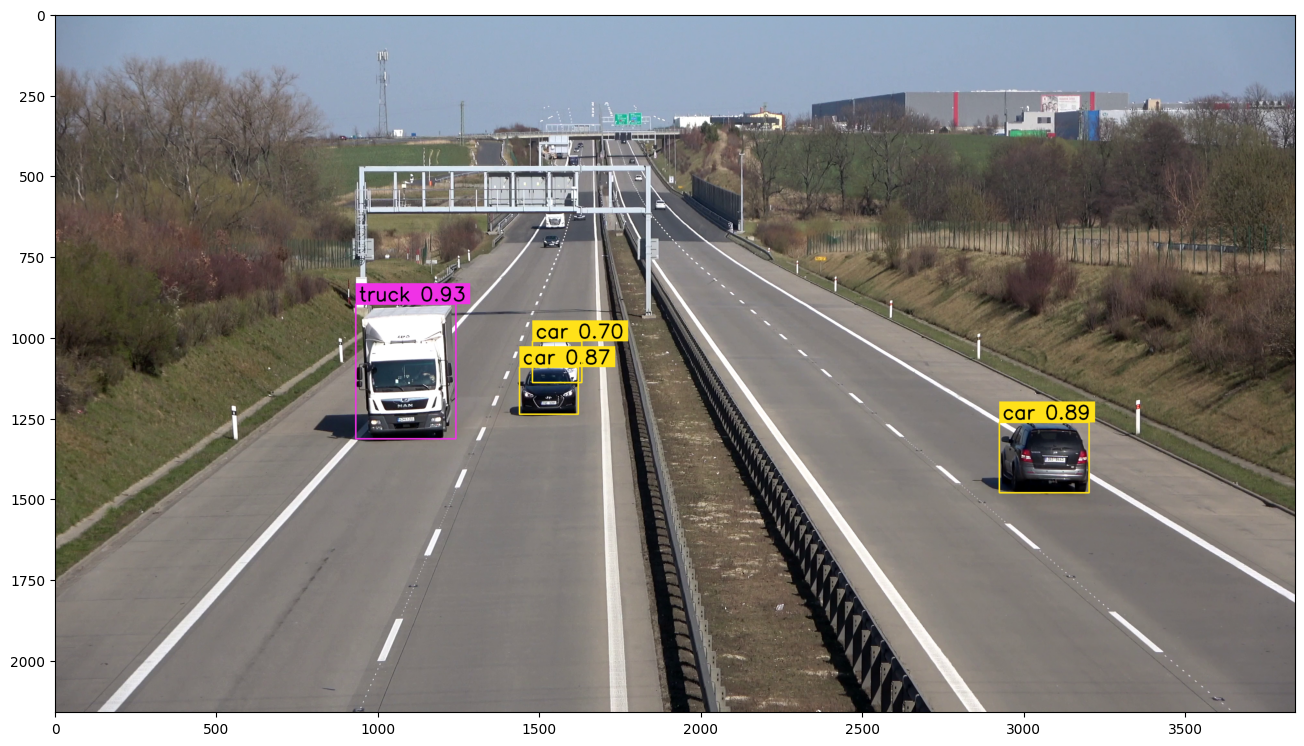

In [ ]:
iterator = iter(generator)
frame = next(iterator)

results = model(frame)
detections = Detections(
    xyxy = results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}" for _, confidence, class_id, tracker_id in detections
]

frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
show_frame_in_notebook(frame, (16, 16))

In [ ]:
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)
TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result.mp4"

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

In [ ]:
byte_tracker = BYTETracker(BYTETrackerArgs())

video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

line_counter = LineCounter(start=LINE_START, end=LINE_END)

box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

In [ ]:
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(generator, total=video_info.total_frames):
        results = model(frame)

        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )

        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )

        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)

        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}" for _, confidence, class_id, tracker_id in detections
        ]

        line_counter.update(detections=detections)

        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/538 [00:00<?, ?it/s]


0: 384x640 3 cars, 1 truck, 551.9ms
Speed: 12.6ms pre-process, 551.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 cars, 1 truck, 526.6ms
Speed: 1.3ms pre-process, 526.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 2 trucks, 527.8ms
Speed: 1.2ms pre-process, 527.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 5 cars, 1 truck, 530.0ms
Speed: 1.2ms pre-process, 530.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 529.2ms
Speed: 2.7ms pre-process, 529.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 528.2ms
Speed: 1.7ms pre-process, 528.2ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 529.3ms
Speed: 1.2ms pre-process, 529.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 5 cars, 1 truck, 532.5ms
Speed: 2.

KeyboardInterrupt: 